In [1]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install -U scikit-learn
!pip install ipympl
!pip install seaborn
!pip install pyarrow
!pip install scipy
!pip install polars
!pip install openpyxl

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import json
from scipy.stats import bootstrap
import scipy.stats as stats
import polars as pl
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.7f}'.format
np.random.seed(42)

In [3]:
def create_box_and_hist(data, column):
    fig, (ax_hist, ax_box) = plt.subplots(2, figsize=(4, 4), gridspec_kw={"height_ratios": (.85, .15)})
    ax_hist.hist(data[column], bins=20, color='skyblue', edgecolor='black')
    ax_hist.set_title('Histogram')
    ax_hist.set_xlabel(f'# {column}')
    ax_box.boxplot(data[column], vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='orange'))
    ax_box.set_xticks([])
    ax_box.set_yticks([])
    plt.tight_layout()
    plt.show()

def boot(data, column, stat, stat_label):
    rnd = 42
    res = bootstrap((data[column].values,), stat, confidence_level=0.9,
                    random_state=rnd, batch=1)
    fig, ax = plt.subplots()
    ax.hist(res.bootstrap_distribution, bins=25)
    ax.set_title('Bootstrap Distribution')
    ax.set_xlabel(stat_label)
    ax.set_ylabel('frequency')
    plt.show()
    return res

def histo(df):
    df.hist()
    plt.tight_layout()
    plt.show()

In [4]:
features = ['products','helpful','funny', 'hours', 'recommended']

In [5]:
# dfreco = pd.read_csv("recommendations.csv")
# dfreco.to_parquet("recommendations.parquet")

In [6]:
dfreco = pl.read_parquet("recommendations.parquet")#.set_index('review_id')
#dfgame = pd.read_csv("games.csv")
#dfuser = pd.read_csv("users.csv")
#dfmeta = pd.read_json('games_metadata.json', lines=False)

In [7]:
dfreco.to_pandas().describe()

,app_id,helpful,funny,hours,user_id,review_id
count,"41,154,794.0000000","41,154,794.0000000","41,154,794.0000000","41,154,794.0000000","41,154,794.0000000","41,154,794.0000000"
mean,"603,272.3585402",3.2025669,1.0580709,100.6022378,"7,450,576.0049239","20,577,396.5000000"
std,"472,923.2816550",46.9364857,28.6706028,176.1675413,"4,010,685.0333110","11,880,365.8415090"
min,10.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
25%,"253,940.0000000",0.0000000,0.0000000,7.8000000,"4,287,256.0000000","10,288,698.2500000"
50%,"435,150.0000000",0.0000000,0.0000000,27.3000000,"7,546,445.5000000","20,577,396.5000000"
75%,"933,110.0000000",0.0000000,0.0000000,99.2000000,"10,968,770.7500000","30,866,094.7500000"
max,"2,253,290.0000000","36,212.0000000","28,109.0000000","1,000.0000000","14,306,063.0000000","41,154,793.0000000"


In [8]:
dfreco.to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
dtypes: bool(1), float64(1), int64(5), object(1)
memory usage: 2.2+ GB


In [9]:
df = dfreco.to_pandas().groupby('user_id').agg({'helpful':'sum', 'funny':'sum', 'app_id': 'nunique', 'is_recommended':'sum', 'hours':'sum'}).rename(columns={'app_id': 'products', 'is_recommended':'recommended'})


In [10]:
from sklearn.decomposition import PCA

X = df[features].values

pca = PCA(n_components=1, random_state=42)
pca_result = pca.fit_transform(X)

df['single_pca'] = pca_result[:,0]
df['single_pca_sort'] = df.single_pca.abs()

In [12]:
pd.DataFrame(pca.components_, columns=features).style.set_caption("Feature Importance with Hours")

,products,helpful,funny,hours,recommended
0,0.007985,0.050837,0.014120,0.998554,0.006520


In [13]:
df[features].corr().style.background_gradient(cmap='coolwarm')

,products,helpful,funny,hours,recommended
products,1.000000,0.356002,0.155323,0.505017,0.940199
helpful,0.356002,1.000000,0.510870,0.194992,0.345501
funny,0.155323,0.510870,1.000000,0.117404,0.152217
hours,0.505017,0.194992,0.117404,1.000000,0.513440
recommended,0.940199,0.345501,0.152217,0.513440,1.000000


In [14]:
features = ['products','helpful','funny']
df[['products','helpful','funny']].corr().style.background_gradient(cmap='coolwarm')

,products,helpful,funny
products,1.000000,0.356002,0.155323
helpful,0.356002,1.000000,0.510870
funny,0.155323,0.510870,1.000000


In [15]:
from sklearn.decomposition import PCA

X = df[features].values

pca = PCA(n_components=1, random_state=42)
pca_result = pca.fit_transform(X)

df['single_pca'] = pca_result[:,0]
#df['single_pca_sort'] = df.single_pca.abs()


In [16]:
pd.DataFrame(pca.components_, columns=features).style.set_caption("Feature Importance without Hours")

,products,helpful,funny
0,0.021895,0.963588,0.266493


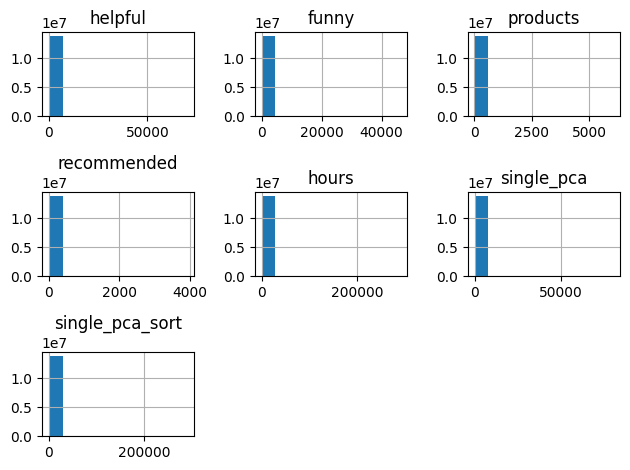

In [17]:
histo(df)
df = df[(df.helpful > 0)&(df.funny > 0)&(df.recommended > 0)&(df.recommended < df.products)&(df.products>10)]

df['helpful_rat'] = df.helpful / df.products
df['funny_rat'] = df.funny / df.products
df['recommended_rat'] = df.recommended / df.products
df['hours_rat'] = df.hours / df.products

df = df[df['single_pca'] >= np.percentile(df['single_pca'].values, 95)]

In [18]:
df.describe()

,helpful,funny,products,recommended,hours,single_pca,single_pca_sort,helpful_rat,funny_rat,recommended_rat,hours_rat
count,"14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000"
mean,"1,802.1380196",515.1559226,78.5941989,60.7171605,"3,137.9535563","1,865.4019539","2,934.7776113",46.0516407,16.2140975,0.7913429,64.3765713
std,"2,476.1035446","1,035.1271434",142.7605063,100.7978846,"4,690.6187437","2,507.9633993","4,707.0903717",64.8077644,37.1373898,0.1610932,56.7887163
min,278.0000000,2.0000000,11.0000000,1.0000000,3.1000000,679.1050127,0.0806100,0.4546875,0.0061350,0.0084034,0.2583333
25%,822.0000000,92.0000000,22.0000000,17.0000000,"1,276.7000000",853.3155541,"1,057.2602074",15.0000000,1.6388889,0.7142857,26.8804440
50%,"1,114.0000000",235.0000000,42.0000000,33.0000000,"2,286.1000000","1,160.3473448","2,069.2164994",29.0789474,4.9506173,0.8333333,48.3785714
75%,"1,796.5000000",583.0000000,85.0000000,68.0000000,"3,830.1500000","1,870.3376159","3,640.1481493",55.1166038,15.4156545,0.9142857,83.4521116
max,"70,096.0000000","46,186.0000000","6,045.0000000","3,920.0000000","290,694.2000000","79,844.6315709","290,676.3714859","2,116.0434783",999.7692308,0.9988675,889.8714286


In [19]:
X = df[features].values
iso = IsolationForest(contamination=0.05, random_state=42)
outliers = iso.fit_predict(X)
scores = iso.decision_function(X)

df["iso"] = outliers
df["iso_score"]  = scores
df['type'] = df['iso'].apply(lambda x: "Outlier" if x == -1 else "Inlier")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14411 entries, 1209 to 14305387
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   helpful          14411 non-null  int64  
 1   funny            14411 non-null  int64  
 2   products         14411 non-null  int64  
 3   recommended      14411 non-null  int64  
 4   hours            14411 non-null  float64
 5   single_pca       14411 non-null  float64
 6   single_pca_sort  14411 non-null  float64
 7   helpful_rat      14411 non-null  float64
 8   funny_rat        14411 non-null  float64
 9   recommended_rat  14411 non-null  float64
 10  hours_rat        14411 non-null  float64
 11  iso              14411 non-null  int64  
 12  iso_score        14411 non-null  float64
 13  type             14411 non-null  object 
dtypes: float64(8), int64(5), object(1)
memory usage: 1.6+ MB


In [20]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
sns_order = ['Outlier', 'Inlier']

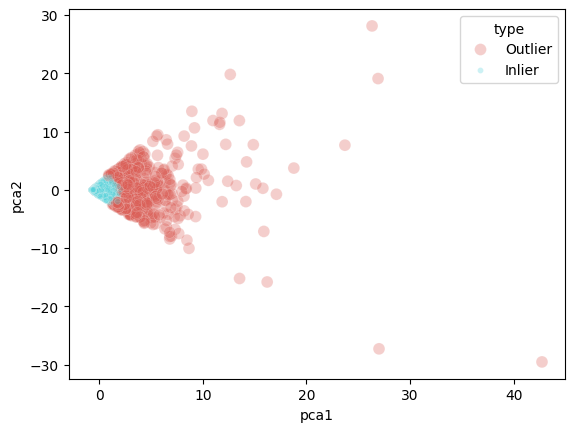

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X)

df['pca1'] = pca_result[:,0]
df['pca2'] = pca_result[:,1] 

sp = sns.scatterplot(
    data=df, 
    x="pca1", 
    y="pca2", 
    hue="type",
    hue_order = sns_order,
    legend=True,
    palette=sns.color_palette("hls", 2),
    size="type",
    size_order = sns_order,
    alpha=0.3
)

plt.show(sp)

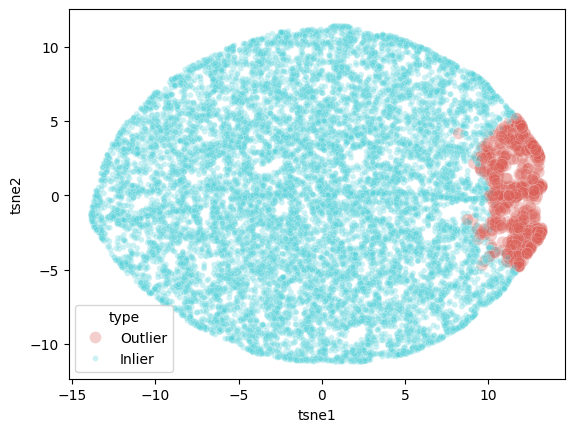

In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=40, max_iter=300, random_state=42)
tsne_results = tsne.fit_transform(X)

df['tsne1'] = tsne_results[:,0]
df['tsne2'] = tsne_results[:,1] 

sp = sns.scatterplot(
    data=df, 
    x="tsne1", 
    y="tsne2", 
    hue="type",
    hue_order = sns_order,
    legend="full",
    palette=sns.color_palette("hls", 2),
    size="type",
    size_order = sns_order,
    alpha=0.3
)

plt.show(sp)

In [23]:
import datetime
data1 = datetime.datetime(2003, 1, 1, 0, 0, 0) #First Possible Launch of Steam
data2 = datetime.datetime.now() 

diff = data2 - data1
hours = diff.days * 24 + diff.seconds // 3600

In [37]:
df_outliers = df[df.iso == -1]
#df_outliers = df_outliers[df_outliers.hours <= hours]

cols = ['user_id', 'products','helpful','funny', 'hours', 'recommended', 'helpful_rat', 'funny_rat', 'recommended_rat', 'hours_rat']
df_outliers = df_outliers.sort_values(by='single_pca', ascending=False)#['products','helpful','funny', 'hours', 'recommended'], ascending=False)
df_outliers.reset_index(inplace=True)
df_outliers.index = np.arange(1, len(df_outliers)+1)
df_outliers.head()

,user_id,helpful,funny,products,recommended,hours,single_pca,single_pca_sort,helpful_rat,funny_rat,recommended_rat,hours_rat,iso,iso_score,type,pca1,pca2,tsne1,tsne2
1,5860500,70096,46186,129,107,"3,922.6000000","79,844.6315709","7,833.6808242",543.3798450,358.0310078,0.8294574,30.4077519,-1,-0.2353141,Outlier,42.7288560,-29.5339404,13.2212677,-2.2164712
2,8040965,65990,1132,1673,1633,"7,642.1000000","63,915.3515326","10,725.1970103",39.4441124,0.6766288,0.9760909,4.5679020,-1,-0.2513936,Outlier,23.7095193,7.6689266,13.2310476,0.7043895
3,9231134,53730,2310,1056,762,"7,558.6000000","52,402.1824244","10,024.5846699",50.8806818,2.1875000,0.7215909,7.1577652,-1,-0.2412895,Outlier,18.7787157,3.7405395,13.2251234,0.6380674
4,11446587,49721,1511,428,325,"12,392.4000000","48,312.4799120","14,628.4440381",116.1705607,3.5303738,0.7593458,28.9542056,-1,-0.1719404,Outlier,15.1009499,1.0057524,13.2119312,0.5772414
5,352264,48669,2929,23,22,313.8000000,"47,667.8055677","2,528.6421277","2,116.0434783",127.3478261,0.9565217,13.6434783,-1,-0.1412413,Outlier,14.1511223,-2.0144876,13.2067232,0.5406791


In [38]:
df_outliers[cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 721 entries, 1 to 721
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          721 non-null    int64  
 1   products         721 non-null    int64  
 2   helpful          721 non-null    int64  
 3   funny            721 non-null    int64  
 4   hours            721 non-null    float64
 5   recommended      721 non-null    int64  
 6   helpful_rat      721 non-null    float64
 7   funny_rat        721 non-null    float64
 8   recommended_rat  721 non-null    float64
 9   hours_rat        721 non-null    float64
dtypes: float64(5), int64(5)
memory usage: 62.0 KB


In [47]:
df_outliers[cols].drop('user_id', axis=1).describe()

,products,helpful,funny,hours,recommended,helpful_rat,funny_rat,recommended_rat,hours_rat
count,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000
mean,356.5894591,"8,408.5963939","2,496.2857143","7,174.2237171",257.2038835,112.3563383,58.9952093,0.7926529,45.1761628
std,494.4211521,"7,461.4337151","3,526.7273497","16,276.7798724",332.3993478,194.7343354,118.1842808,0.1802959,55.6702751
min,11.0000000,601.0000000,4.0000000,141.1000000,1.0000000,0.4546875,0.0083160,0.0084034,0.8693522
25%,48.0000000,"3,614.0000000",445.0000000,"2,451.4000000",40.0000000,14.1432507,1.0152284,0.7234568,11.9966472
50%,212.0000000,"7,059.0000000","1,322.0000000","4,380.5000000",159.0000000,43.5185185,6.8275862,0.8365385,26.2168421
75%,505.0000000,"10,564.0000000","3,717.0000000","7,558.6000000",352.0000000,123.5714286,54.3437500,0.9245283,59.2575000
max,"6,045.0000000","70,096.0000000","46,186.0000000","290,694.2000000","3,920.0000000","2,116.0434783",999.7692308,0.9988675,512.0131944


In [48]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_outliers[cols].style.format(precision=2))

,user_id,products,helpful,funny,hours,recommended,helpful_rat,funny_rat,recommended_rat,hours_rat
1,5860500,129,70096,46186,3922.60,107,543.38,358.03,0.83,30.41
2,8040965,1673,65990,1132,7642.10,1633,39.44,0.68,0.98,4.57
3,9231134,1056,53730,2310,7558.60,762,50.88,2.19,0.72,7.16
4,11446587,428,49721,1511,12392.40,325,116.17,3.53,0.76,28.95
5,352264,23,48669,2929,313.80,22,2116.04,127.35,0.96,13.64
6,11451103,620,44896,4202,16059.40,563,72.41,6.78,0.91,25.90
7,5112758,4152,42745,3510,8404.20,3920,10.30,0.85,0.94,2.02
8,3963306,433,42050,1997,6437.20,387,97.11,4.61,0.89,14.87
9,8865664,879,39597,7905,8199.50,872,45.05,8.99,0.99,9.33
10,8568403,617,36180,2369,12589.70,462,58.64,3.84,0.75,20.40


In [49]:
print(f'Original user count: {dfreco.to_pandas().user_id.nunique()}')
print(f'User candidate count: {len(df)}')
print(f'Anomaly user count: {len(df_outliers)}')

Original user count: 13781059
User candidate count: 14411
Anomaly user count: 721


In [ ]:
df_outliers.to_excel('outlier_users.xlsx')